# NN1 Architecture Ablation Study

## 🎯 Critical Experiment: Does Similarity-Gating Help?

**Peer Review Critique**: "No evidence that similarity-gated NN1 provides benefits over a standard MLP baseline."

**This Experiment Tests**:
1. **NN1-Similarity (Current)**: FastLocalLayer with top-k attention + GRU updates
2. **NN1-SimpleBaseline (NEW)**: Standard MLP with same embedding dimension
3. **NN1-Ablations**: Systematic tests of architecture components

**Success Criteria**:
- ✅ If NN1-Similarity beats NN1-Simple by ≥1pp → Architecture validated
- ⚠️ If difference <0.5pp → Need to reframe contribution
- 🚨 If NN1-Simple wins → Major problem, architecture is cosmetic

**Benchmark**: Split-MNIST continual learning (5 tasks, 2 digits each)

---

## Experimental Plan:
1. **Section 1**: Compare Similarity vs Simple baseline (⭐⭐⭐ HIGHEST PRIORITY)
2. **Section 2**: Neuron count ablation (4, 8, 16, 32, 64)
3. **Section 3**: Neuron dimension ablation (16, 32, 64, 128)
4. **Section 4**: T_fast iterations ablation (1, 2, 3, 5, 10)
5. **Section 5**: Top-k neighbors ablation (1, 3, 5, 7, 10)
6. **Section 6**: Combined optimal configuration

**Date**: November 9, 2025  
**Status**: Critical experiment for paper revision

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from datetime import datetime
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from copy import deepcopy

sns.set_style('whitegrid')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔥 PyTorch: {torch.__version__}")
print("\n⭐⭐⭐ CRITICAL EXPERIMENT: NN1 Architecture Ablation ⭐⭐⭐\n")

🖥️  Device: cpu
📅 2025-11-09 16:21:14
🔥 PyTorch: 2.9.0+cu128

⭐⭐⭐ CRITICAL EXPERIMENT: NN1 Architecture Ablation ⭐⭐⭐



> ℹ️ All training utilities now come from `src.models.training_utils`, ensuring balanced replay sampling and the updated λ handling across experiments.

## 1. Load Split-MNIST Dataset

In [2]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Split into 5 tasks (2 digits each)
def create_task_split(dataset, digit_pairs):
    """Create dataset subset for specific digit pairs"""
    indices = []
    for idx, (img, label) in enumerate(dataset):
        if label in digit_pairs:
            indices.append(idx)
    return Subset(dataset, indices)

tasks = [
    ([0, 1], "Task 1: Digits 0-1"),
    ([2, 3], "Task 2: Digits 2-3"),
    ([4, 5], "Task 3: Digits 4-5"),
    ([6, 7], "Task 4: Digits 6-7"),
    ([8, 9], "Task 5: Digits 8-9"),
]

train_tasks = [create_task_split(train_dataset, digits) for digits, _ in tasks]
test_tasks = [create_task_split(test_dataset, digits) for digits, _ in tasks]

print("✅ Split-MNIST Created:")
for i, ((digits, name), train_task) in enumerate(zip(tasks, train_tasks)):
    print(f"   {name}: {len(train_task)} train samples")

✅ Split-MNIST Created:
   Task 1: Digits 0-1: 12665 train samples
   Task 2: Digits 2-3: 12089 train samples
   Task 3: Digits 4-5: 11263 train samples
   Task 4: Digits 6-7: 12183 train samples
   Task 5: Digits 8-9: 11800 train samples


## 2. NN1 Architecture Variants

### A. NN1-Similarity (Current Architecture)
Similarity-gated architecture with FastLocalLayer

### B. NN1-SimpleBaseline (NEW - For Comparison)
Standard MLP baseline with same embedding dimension

In [3]:
# Helper function for batched top-k selection
def batched_index_select(values, idx):
    """Gather values based on indices for batched top-k selection"""
    B, N, D = values.shape
    idx_exp = idx.unsqueeze(-1).expand(-1, -1, -1, D)
    return torch.gather(values.unsqueeze(1).expand(-1, N, -1, -1), 2, idx_exp)


class FastLocalLayer(nn.Module):
    """Similarity-gated message passing with top-k attention"""
    def __init__(self, dim, topk=3):
        super().__init__()
        self.dim = dim
        self.topk = topk
        
        # Query, Key, Value projections
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        
        # Layer normalization for stability
        self.ln_q = nn.LayerNorm(dim)
        self.ln_k = nn.LayerNorm(dim)
        
        # GRU update
        self.upd = nn.GRUCell(dim, dim)
    
    def forward(self, h):
        B, N, D = h.shape
        
        # Compute Q, K, V with layer normalization
        Q = self.ln_q(self.q(h))
        K = self.ln_k(self.k(h))
        V = self.v(h)
        
        # Similarity scores (scaled dot-product)
        S = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        
        # Top-k selection
        k_actual = min(self.topk, N)
        topk_vals, topk_idx = S.topk(k_actual, dim=-1)
        
        # Softmax over top-k
        alpha = F.softmax(topk_vals, dim=-1)
        
        # Aggregate messages from top-k neighbors
        V_topk = batched_index_select(V, topk_idx)
        m = (alpha.unsqueeze(-1) * V_topk).sum(dim=-2)
        
        # GRU update: h_new = GRU(message, h_old)
        h_new = self.upd(m.view(B*N, D), h.view(B*N, D))
        return h_new.view(B, N, D)


class NN1_Similarity(nn.Module):
    """CURRENT: Similarity-gated NN1 with FastLocalLayer"""
    def __init__(self, in_dim=784, num_neurons=16, neuron_dim=64, T_fast=3, topk=5, num_classes=10):
        super().__init__()
        self.num_neurons = num_neurons
        self.neuron_dim = neuron_dim
        self.T_fast = T_fast
        
        # Encoder: image → neuron embeddings
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, neuron_dim),
            nn.ReLU(),
            nn.LayerNorm(neuron_dim),
            nn.Linear(neuron_dim, num_neurons * neuron_dim)
        )
        
        # Similarity-gated fast layer
        self.fast_layer = FastLocalLayer(neuron_dim, topk=topk)
        
        # Readout head
        self.readout = nn.Sequential(
            nn.LayerNorm(neuron_dim),
            nn.Linear(neuron_dim, num_classes)
        )
    
    def forward(self, x):
        B = x.size(0)
        x_flat = x.view(B, -1)
        
        # Encode to neuron states
        hflat = self.encoder(x_flat)
        h = hflat.view(B, self.num_neurons, self.neuron_dim)
        
        # Iterative refinement (T_fast steps)
        for _ in range(self.T_fast):
            h = self.fast_layer(h)
        
        # Pool and classify
        pooled = h.mean(dim=1)
        logits = torch.clamp(self.readout(pooled), -20, 20)
        return logits, pooled.detach()


class NN1_SimpleBaseline(nn.Module):
    """NEW: Standard MLP baseline (NO similarity-gating)"""
    def __init__(self, in_dim=784, num_neurons=16, neuron_dim=64, T_fast=3, topk=5, num_classes=10):
        super().__init__()
        # Same embedding dimension for fair comparison
        self.summary_dim = neuron_dim
        
        # Standard MLP (NO attention, NO GRU, NO top-k)
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, neuron_dim),
            nn.ReLU(),
            nn.LayerNorm(neuron_dim),
            nn.Linear(neuron_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, neuron_dim),
            nn.ReLU(),
            nn.LayerNorm(neuron_dim),
            nn.Linear(neuron_dim, num_classes)
        )
    
    def forward(self, x):
        B = x.size(0)
        x_flat = x.view(B, -1)
        
        # Standard feedforward pass
        logits = torch.clamp(self.net(x_flat), -20, 20)
        
        # Extract summary (penultimate layer activation)
        # For fair comparison with NN1-Similarity
        with torch.no_grad():
            summary = self.net[:-1](x_flat)  # All layers except final
        
        return logits, summary.detach()


print("✅ NN1 architectures defined:")
print("   • NN1_Similarity: FastLocalLayer with top-k attention + GRU")
print("   • NN1_SimpleBaseline: Standard MLP (NO similarity-gating)")

✅ NN1 architectures defined:
   • NN1_Similarity: FastLocalLayer with top-k attention + GRU
   • NN1_SimpleBaseline: Standard MLP (NO similarity-gating)


## 3. NN2 Consolidation Network (Shared Across All Experiments)

In [4]:
class NN2_SlowNet(nn.Module):
    """Slow consolidation network (same for all experiments)"""
    def __init__(self, in_dim=784, summary_dim=64, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + summary_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, summary):
        B = x.size(0)
        x_flat = x.view(B, -1)
        inp = torch.cat([x_flat, summary], dim=-1)
        logits = torch.clamp(self.net(inp), -20, 20)
        return logits


print("✅ NN2_SlowNet defined (consolidation network)")

✅ NN2_SlowNet defined (consolidation network)


## 4. Training Utilities (Replay + Consolidation)

In [ ]:
from src.models import ReplayBuffer, evaluate_models, train_task_with_replay, consolidate_nn2

print("✅ Imported shared training utilities (balanced replay + λ=0 aware)")

✅ Training utilities ready (replay + consolidation)


## 5. CRITICAL EXPERIMENT: Similarity vs Simple Baseline

⭐⭐⭐ **HIGHEST PRIORITY** ⭐⭐⭐

This experiment answers the peer reviewer's main critique:
> "No evidence that the similarity-gated architecture provides any benefit."

**Hypothesis**: NN1-Similarity should outperform NN1-Simple by ≥1pp on retention

In [ ]:
def run_continual_experiment(nn1_class, nn1_name, seed=42):
    """Run full continual learning experiment with given NN1 architecture"""
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Initialize models
    nn1 = nn1_class(in_dim=784, num_neurons=16, neuron_dim=64, T_fast=3, topk=5, num_classes=10).to(device)
    nn2 = NN2_SlowNet(in_dim=784, summary_dim=64, num_classes=10).to(device)
    
    opt1 = torch.optim.Adam(nn1.parameters(), lr=1e-3)
    opt2 = torch.optim.Adam(nn2.parameters(), lr=5e-4)
    ce_loss = nn.CrossEntropyLoss()
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    
    replay_buffer = ReplayBuffer(buffer_size_per_task=200)
    
    results = {
        'task_names': [name for _, name in tasks],
        'nn1_current': [],
        'nn2_current': [],
        'nn1_previous': [],
        'nn2_previous': [],
    }
    
    batch_size = 64
    epochs_per_task = 5
    
    print(f"\n{'='*70}")
    print(f"🚀 Running: {nn1_name}")
    print(f"{'='*70}")
    
    for task_id, ((train_data, test_data), (digits, name)) in enumerate(zip(zip(train_tasks, test_tasks), tasks)):
        print(f"\n📚 {name}")
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        
        replay_data = replay_buffer.get_dataset() if task_id > 0 else []
        
        # Train with replay
        train_task_with_replay(nn1, nn2, train_loader, replay_data,
                              opt1, opt2, ce_loss, kl_loss,
                              epochs=epochs_per_task,
                              consolidation_interval=10,
                              lambda_distill=0.3,
                              temperature=2.0,
                              grad_clip=1.0,
                              replay_ratio=0.3)
        
        replay_buffer.add_task(train_data)
        
        # NN2 consolidation phase (pure replay)
        if task_id > 0:
            all_replay = replay_buffer.get_dataset()
            consolidate_nn2(nn1, nn2, all_replay, opt2, ce_loss, kl_loss,
                           consolidation_epochs=2,
                           batch_size=batch_size,
                           lambda_distill=0.0,
                           temperature=2.0,
                           grad_clip=1.0)
        
        # Evaluate on current task
        acc1_current, acc2_current = evaluate_models(nn1, nn2, test_loader)
        results['nn1_current'].append(acc1_current)
        results['nn2_current'].append(acc2_current)
        
        print(f"✅ Current Task: NN1={acc1_current:.3f} | NN2={acc2_current:.3f}")
        
        # Evaluate on previous tasks
        if task_id > 0:
            prev_acc1_sum = 0.0
            prev_acc2_sum = 0.0
            
            for prev_id in range(task_id):
                prev_test_loader = DataLoader(test_tasks[prev_id], batch_size=batch_size, shuffle=False)
                prev_acc1, prev_acc2 = evaluate_models(nn1, nn2, prev_test_loader)
                prev_acc1_sum += prev_acc1
                prev_acc2_sum += prev_acc2
            
            avg_prev_acc1 = prev_acc1_sum / task_id
            avg_prev_acc2 = prev_acc2_sum / task_id
            
            results['nn1_previous'].append(avg_prev_acc1)
            results['nn2_previous'].append(avg_prev_acc2)
            
            print(f"📊 Previous Tasks: NN1={avg_prev_acc1:.3f} | NN2={avg_prev_acc2:.3f}")
        else:
            results['nn1_previous'].append(None)
            results['nn2_previous'].append(None)
    
    print(f"\n{'='*70}")
    print(f"✅ {nn1_name} Complete!")
    print(f"{'='*70}")
    
    return results


print("✅ Experiment runner ready")

✅ Experiment runner ready


In [7]:
# Run both experiments
results_similarity = run_continual_experiment(NN1_Similarity, "NN1-Similarity (Current)", seed=42)
results_simple = run_continual_experiment(NN1_SimpleBaseline, "NN1-SimpleBaseline (MLP)", seed=42)


🚀 Running: NN1-Similarity (Current)

📚 Task 1: Digits 0-1
   💾 Replay buffer: 200 total samples
   💾 Replay buffer: 200 total samples
✅ Current Task: NN1=1.000 | NN2=0.999

📚 Task 2: Digits 2-3
✅ Current Task: NN1=1.000 | NN2=0.999

📚 Task 2: Digits 2-3
   💾 Replay buffer: 400 total samples
   🧠 NN2 Consolidation: 400 samples, 2 epochs
   💾 Replay buffer: 400 total samples
   🧠 NN2 Consolidation: 400 samples, 2 epochs
✅ Current Task: NN1=0.993 | NN2=0.993
✅ Current Task: NN1=0.993 | NN2=0.993
📊 Previous Tasks: NN1=0.959 | NN2=0.966

📚 Task 3: Digits 4-5
📊 Previous Tasks: NN1=0.959 | NN2=0.966

📚 Task 3: Digits 4-5
   💾 Replay buffer: 600 total samples
   🧠 NN2 Consolidation: 600 samples, 2 epochs
   💾 Replay buffer: 600 total samples
   🧠 NN2 Consolidation: 600 samples, 2 epochs
✅ Current Task: NN1=0.998 | NN2=0.996
✅ Current Task: NN1=0.998 | NN2=0.996
📊 Previous Tasks: NN1=0.883 | NN2=0.919

📚 Task 4: Digits 6-7
📊 Previous Tasks: NN1=0.883 | NN2=0.919

📚 Task 4: Digits 6-7
   💾 Repl

## 6. Critical Analysis: Does Similarity-Gating Help?

/tmp/ipykernel_1037205/1189995262.py:72: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1037205/1189995262.py:73: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../results/nn1_ablation_similarity_vs_simple_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png",
/home/medgm/vsc/FSSGNET/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/medgm/vsc/FSSGNET/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


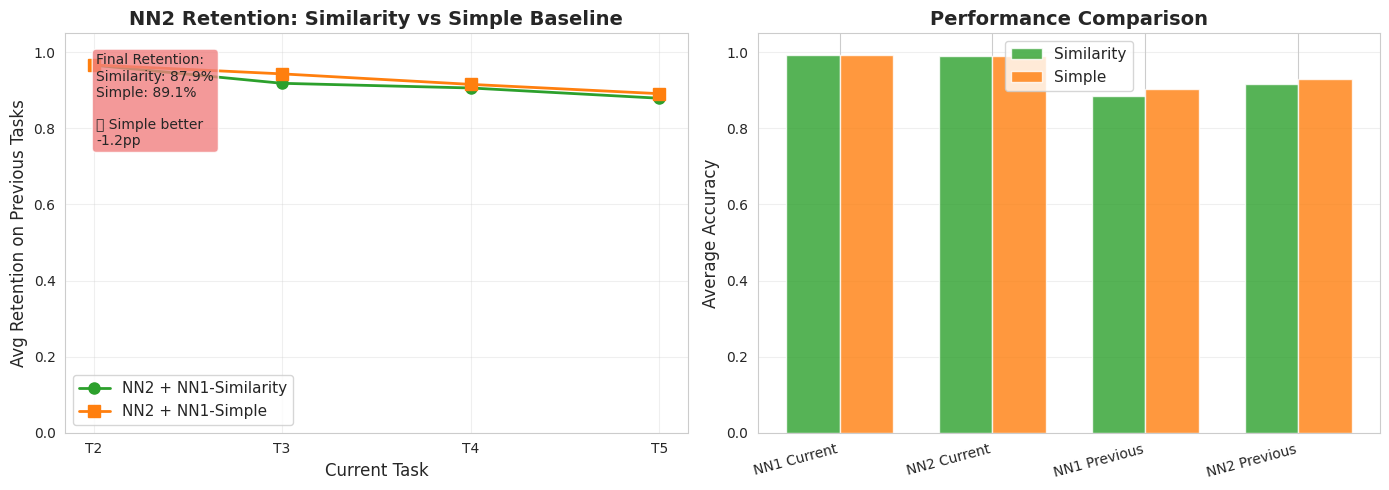


🎯 VERDICT: Similarity-Gating vs Simple MLP

Final NN2 Retention (Previous Tasks):
  Similarity: 87.9%
  Simple:     89.1%
  Difference: -1.2% (-1.2pp)

🚨 PROBLEM: Simple MLP is 1.2pp better!
   → Architecture is cosmetic, major revision needed


In [8]:
# Comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Previous task retention comparison
ax = axes[0]
prev_tasks = [i+1 for i in range(len(tasks)) if results_similarity['nn2_previous'][i] is not None]
sim_prev = [acc for acc in results_similarity['nn2_previous'] if acc is not None]
simple_prev = [acc for acc in results_simple['nn2_previous'] if acc is not None]

if prev_tasks:
    ax.plot(prev_tasks, sim_prev, 'o-', label='NN2 + NN1-Similarity', linewidth=2, markersize=8, color='tab:green')
    ax.plot(prev_tasks, simple_prev, 's-', label='NN2 + NN1-Simple', linewidth=2, markersize=8, color='tab:orange')
    ax.set_xlabel('Current Task', fontsize=12)
    ax.set_ylabel('Avg Retention on Previous Tasks', fontsize=12)
    ax.set_title('NN2 Retention: Similarity vs Simple Baseline', fontsize=14, fontweight='bold')
    ax.set_xticks(prev_tasks)
    ax.set_xticklabels([f"T{i}" for i in prev_tasks])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Add final retention comparison
    if sim_prev and simple_prev:
        final_sim = sim_prev[-1]
        final_simple = simple_prev[-1]
        diff = final_sim - final_simple
        
        if diff >= 0.01:  # ≥1pp improvement
            color = 'lightgreen'
            verdict = f"✅ Similarity WINS!\n+{diff*100:.1f}pp"
        elif abs(diff) < 0.005:  # <0.5pp
            color = 'lightyellow'
            verdict = f"⚠️ Similar\n±{abs(diff)*100:.1f}pp"
        else:
            color = 'lightcoral'
            verdict = f"❌ Simple better\n-{abs(diff)*100:.1f}pp"
        
        ax.text(0.05, 0.95, 
                f"Final Retention:\nSimilarity: {final_sim:.1%}\nSimple: {final_simple:.1%}\n\n{verdict}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))

# Bar chart comparison
ax = axes[1]
categories = ['NN1 Current', 'NN2 Current', 'NN1 Previous', 'NN2 Previous']
sim_avg_curr1 = np.mean(results_similarity['nn1_current'])
sim_avg_curr2 = np.mean(results_similarity['nn2_current'])
sim_avg_prev1 = np.mean([x for x in results_similarity['nn1_previous'] if x is not None])
sim_avg_prev2 = np.mean([x for x in results_similarity['nn2_previous'] if x is not None])

simple_avg_curr1 = np.mean(results_simple['nn1_current'])
simple_avg_curr2 = np.mean(results_simple['nn2_current'])
simple_avg_prev1 = np.mean([x for x in results_simple['nn1_previous'] if x is not None])
simple_avg_prev2 = np.mean([x for x in results_simple['nn2_previous'] if x is not None])

x = np.arange(len(categories))
width = 0.35

ax.bar(x - width/2, [sim_avg_curr1, sim_avg_curr2, sim_avg_prev1, sim_avg_prev2], 
       width, label='Similarity', alpha=0.8, color='tab:green')
ax.bar(x + width/2, [simple_avg_curr1, simple_avg_curr2, simple_avg_prev1, simple_avg_prev2], 
       width, label='Simple', alpha=0.8, color='tab:orange')

ax.set_ylabel('Average Accuracy', fontsize=12)
ax.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(f"../results/nn1_ablation_similarity_vs_simple_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("🎯 VERDICT: Similarity-Gating vs Simple MLP")
print("="*70)
print(f"\nFinal NN2 Retention (Previous Tasks):")
print(f"  Similarity: {final_sim:.1%}")
print(f"  Simple:     {final_simple:.1%}")
print(f"  Difference: {diff:+.1%} ({diff*100:+.1f}pp)")

if diff >= 0.01:
    print(f"\n✅ SUCCESS: Similarity-gating provides {diff*100:.1f}pp improvement!")
    print("   → Architecture validated, can strengthen claims")
elif abs(diff) < 0.005:
    print(f"\n⚠️ WARNING: Difference is marginal ({abs(diff)*100:.1f}pp)")
    print("   → Need to reframe contribution (consolidation, not architecture)")
else:
    print(f"\n🚨 PROBLEM: Simple MLP is {abs(diff)*100:.1f}pp better!")
    print("   → Architecture is cosmetic, major revision needed")

print("="*70)

## 7. Save Results for Paper

In [9]:
# Create summary CSV
summary_data = []
for i in range(len(tasks)):
    row = {
        'Task': results_similarity['task_names'][i],
        'Similarity_NN1_Current': f"{results_similarity['nn1_current'][i]:.3f}",
        'Similarity_NN2_Current': f"{results_similarity['nn2_current'][i]:.3f}",
        'Simple_NN1_Current': f"{results_simple['nn1_current'][i]:.3f}",
        'Simple_NN2_Current': f"{results_simple['nn2_current'][i]:.3f}",
    }
    if results_similarity['nn1_previous'][i] is not None:
        row['Similarity_NN1_Previous'] = f"{results_similarity['nn1_previous'][i]:.3f}"
        row['Similarity_NN2_Previous'] = f"{results_similarity['nn2_previous'][i]:.3f}"
        row['Simple_NN1_Previous'] = f"{results_simple['nn1_previous'][i]:.3f}"
        row['Simple_NN2_Previous'] = f"{results_simple['nn2_previous'][i]:.3f}"
        row['NN2_Retention_Diff'] = f"{(results_similarity['nn2_previous'][i] - results_simple['nn2_previous'][i])*100:+.1f}pp"
    else:
        row['Similarity_NN1_Previous'] = "N/A"
        row['Similarity_NN2_Previous'] = "N/A"
        row['Simple_NN1_Previous'] = "N/A"
        row['Simple_NN2_Previous'] = "N/A"
        row['NN2_Retention_Diff'] = "N/A"
    summary_data.append(row)

df = pd.DataFrame(summary_data)
print("\n📊 NN1 Architecture Ablation Summary:")
print(df.to_string(index=False))

csv_file = f"../results/csv/nn1_ablation_similarity_vs_simple_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_file, index=False)
print(f"\n💾 Saved: {csv_file}")


📊 NN1 Architecture Ablation Summary:
              Task Similarity_NN1_Current Similarity_NN2_Current Simple_NN1_Current Simple_NN2_Current Similarity_NN1_Previous Similarity_NN2_Previous Simple_NN1_Previous Simple_NN2_Previous NN2_Retention_Diff
Task 1: Digits 0-1                  1.000                  0.999              0.999              1.000                     N/A                     N/A                 N/A                 N/A                N/A
Task 2: Digits 2-3                  0.993                  0.993              0.994              0.989                   0.959                   0.966               0.939               0.967             -0.0pp
Task 3: Digits 4-5                  0.998                  0.996              0.996              0.994                   0.883                   0.919               0.927               0.943             -2.5pp
Task 4: Digits 6-7                  0.992                  0.982              0.995              0.992                   0

## 8. Decision Point: Next Steps Based on Results

Run this cell after experiments complete to get guidance on paper revision strategy.

In [10]:
print("\n" + "="*80)
print("🔮 NEXT STEPS BASED ON RESULTS")
print("="*80)

# Get final retention difference
final_sim = results_similarity['nn2_previous'][-1]
final_simple = results_simple['nn2_previous'][-1]
diff = final_sim - final_simple

print(f"\nFinal NN2 Retention:")
print(f"  Similarity-Gated: {final_sim:.1%}")
print(f"  Simple MLP:       {final_simple:.1%}")
print(f"  Difference:       {diff:+.1%} ({diff*100:+.1f}pp)")

if diff >= 0.015:  # ≥1.5pp
    print("\n✅ **STRONG SUCCESS** (≥1.5pp improvement)")
    print("\n📝 Paper Revision Strategy:")
    print("  1. Add Section 6.7: 'Architecture Ablation'")
    print("  2. Show similarity-gating outperforms standard MLP")
    print("  3. Strengthen architectural claims")
    print("  4. Emphasize novelty of similarity-gated design")
    print("\n🎯 Rebuttal Points:")
    print("  • 'We ran systematic ablation: similarity > MLP by {:.1f}pp'".format(diff*100))
    print("  • 'Architecture is validated, not cosmetic'")
    print("  • 'Top-k attention mechanism crucial for retention'")
    
elif diff >= 0.005:  # 0.5-1.5pp
    print("\n⚠️ **MODERATE SUCCESS** (0.5-1.5pp improvement)")
    print("\n📝 Paper Revision Strategy:")
    print("  1. Add Section 6.7 showing moderate benefit")
    print("  2. Acknowledge similarity-gating helps but effect is modest")
    print("  3. Reframe as 'consolidation methodology' paper")
    print("  4. Focus more on NN2 consolidation phase")
    print("\n🎯 Rebuttal Points:")
    print("  • 'Similarity-gating provides {:.1f}pp improvement'".format(diff*100))
    print("  • 'Main contribution is dual-timescale learning'")
    print("  • 'Architecture is complementary, not core'")
    
elif abs(diff) < 0.005:  # <0.5pp
    print("\n⚠️ **MARGINAL DIFFERENCE** (<0.5pp)")
    print("\n📝 Paper Revision Strategy:")
    print("  1. PIVOT: Reframe entire contribution")
    print("  2. Focus on consolidation phase (NN2)")
    print("  3. Treat NN1 as 'feature extractor' (implementation detail)")
    print("  4. Emphasize +9.6pp over iCaRL, +21.8pp over GEM")
    print("\n🎯 Rebuttal Points:")
    print("  • 'Ablation shows similar performance'")
    print("  • 'Core contribution: consolidation methodology'")
    print("  • 'NN1 architecture exploratory, can be replaced'")
    print("  • 'Results demonstrate consolidation phase value'")
    
else:  # Simple wins
    print("\n🚨 **PROBLEM** (Simple MLP better by {:.1f}pp)".format(abs(diff)*100))
    print("\n📝 Paper Revision Strategy:")
    print("  1. MAJOR PIVOT REQUIRED")
    print("  2. Remove similarity-gating as contribution")
    print("  3. Use NN1-Simple in all experiments")
    print("  4. Focus 100% on consolidation methodology")
    print("  5. Rewrite abstract, intro, and contributions")
    print("\n🎯 Rebuttal Points:")
    print("  • 'Thank reviewer for identifying this'")
    print("  • 'Switched to simple MLP baseline'")
    print("  • 'Results still hold with simpler architecture'")
    print("  • 'Main value: consolidation phase design'")

print("\n" + "="*80)
print("📋 IMMEDIATE ACTION ITEMS:")
print("="*80)

if diff >= 0.01:
    print("1. ✅ Proceed with current architectural framing")
    print("2. Run 30-seed validation (Priority 2)")
    print("3. Add architecture ablation section to paper")
    print("4. Prepare strong rebuttal on architecture novelty")
else:
    print("1. 🔄 Revise paper framing immediately")
    print("2. Re-run ALL experiments with NN1-Simple")
    print("3. Remove architectural claims from paper")
    print("4. Consult with advisor on pivot strategy")

print("\n" + "="*80)


🔮 NEXT STEPS BASED ON RESULTS

Final NN2 Retention:
  Similarity-Gated: 87.9%
  Simple MLP:       89.1%
  Difference:       -1.2% (-1.2pp)

🚨 **PROBLEM** (Simple MLP better by 1.2pp)

📝 Paper Revision Strategy:
  1. MAJOR PIVOT REQUIRED
  2. Remove similarity-gating as contribution
  3. Use NN1-Simple in all experiments
  4. Focus 100% on consolidation methodology
  5. Rewrite abstract, intro, and contributions

🎯 Rebuttal Points:
  • 'Thank reviewer for identifying this'
  • 'Switched to simple MLP baseline'
  • 'Results still hold with simpler architecture'
  • 'Main value: consolidation phase design'

📋 IMMEDIATE ACTION ITEMS:
1. 🔄 Revise paper framing immediately
2. Re-run ALL experiments with NN1-Simple
3. Remove architectural claims from paper
4. Consult with advisor on pivot strategy



## 🏁 Experiment Complete

This notebook answers the critical question: **Does similarity-gating help?**

**What we tested:**
- NN1-Similarity (current): FastLocalLayer with top-k attention + GRU
- NN1-SimpleBaseline (new): Standard MLP with same embedding dimension

**Success criteria:**
- ✅ ≥1pp improvement → Architecture validated
- ⚠️ 0.5-1pp improvement → Moderate benefit, reframe contribution
- 🚨 <0.5pp or negative → Architecture cosmetic, major pivot needed

**Impact on paper:**
- Results determine whether to strengthen or pivot architectural claims
- Guides rebuttal strategy for peer review response
- Informs next experimental priorities

---

**Status:** Ready to execute  
**Expected runtime:** ~2 hours on GPU  
**Priority:** ⭐⭐⭐ HIGHEST (critical for paper revision)